In [159]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDRegressor,SGDClassifier
from sklearn.pipeline import Pipeline
from scipy import sparse
from sklearn.preprocessing import StandardScaler, MaxAbsScaler,LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
import warnings
import pickle
from nltk.corpus import stopwords
import nltk
import seaborn as sns
import re
import gc
import string
import lightgbm
import pymorphy2
from nltk.tokenize.casual import TweetTokenizer
from mlxtend.text import tokenizer_emoticons
#import spacy
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import itertools
#import numpy as np
from scipy import stats
import pylab as pl
from sklearn import svm, linear_model, cross_validation

In [91]:
def tokenize_me(file_text):
    #firstly let's apply nltk tokenization
    tokens = file_text.split(' ')

    #let's delete punctuation symbols
    #tokens = [i for i in tokens if ( i not in string.punctuation )]

    #deleting stop_words
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    tokens = [i for i in tokens if ( i not in stop_words )]

    #cleaning words

    tokens = [morph.parse(i)[0].normal_form if i not in string.punctuation else i for i in tokens ]
     
    return ' '.join(tokens)

In [4]:
def get_tfidf(texts):
    vectorizer = TfidfVectorizer(encoding='unicode',
                                                  ngram_range= (1, 1), 
                                                  min_df=3,#3-оптимум
                                                  #use_idf=False,
                                                  #sublinear_tf=True,
                                                  tokenizer=TweetTokenizer().tokenize,
                                                  #stop_words=stop_words,
                                                  analyzer='word')
    matrix = vectorizer.fit_transform(texts)
    tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
    return tfidf, matrix

In [5]:
def featurize_w2v(model, sentences, tfidf, vsize=300):
    f = np.zeros((len(sentences), vsize))
    for i,s in enumerate(sentences):
        #count = 0.
        for w in s.split():
            try:
                vec = model[w].reshape((1, vsize))*tfidf[w]
                #count +=1.
            except KeyError:
                continue
            f[i,:] = f[i,:] + vec
        if len(s) !=0: #count != 0:
            f[i,:] = f[i,:] / len(s)
    return f

In [6]:
def get_all_words(data):
    all_words=[]
    for file_text in data:
        tokens = TweetTokenizer().tokenize(file_text)
        #let's delete punctuation symbols
        tokens = [i for i in tokens if ( i not in string.punctuation and i not in stop_words )]
        all_words+=tokens
    return all_words

In [9]:
from sklearn.metrics import make_scorer

In [ ]:
w2v=pickle.load(open('word_vectors.pkl', "rb"))

In [10]:
stop_words = stopwords.words('russian')

In [11]:
def word_count(text):
    return len(text.split())

In [12]:
def unique_word(text):
    return len(set(text.split()))

In [13]:
def ne_count(text):
    ne_cnt=[txt for txt in  text.split() if 'не' in txt or 'ни' in text or 'но' in txt or 'иначе' in txt or 'а' in txt]
    return len(ne_cnt)

In [15]:
morph = pymorphy2.MorphAnalyzer()

In [688]:
import seaborn as sns
sns.set()

In [21]:
from sklearn.utils import shuffle

In [22]:
from sklearn.model_selection import GridSearchCV

### Pipe

In [67]:
def MyPipe(model, scaler):
    #pipe = pipeline.Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', model)])
    pipe = Pipeline([('vect', TfidfVectorizer(
                                              ngram_range=(1, 3), min_df=3, 
                                              tokenizer=TweetTokenizer().tokenize,
                                              stop_words = stopwords.words('russian')
                                             ))
                     ,('scaler', scaler),('clf', model)])
    return pipe

In [68]:
def MyPipe2(model, scaler):
    #pipe = pipeline.Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', model)])
    pipe = Pipeline([('scaler', scaler),('clf', model)])
    return pipe

### Sentiment модель на твитах
http://study.mokoron.com - открытый корпус РУССКИХ твитов

In [112]:
name_col=["id",
"tdate",
"tname",
"ttext",
"ttype",
"trep","trtw",
"tfav",
"tstcount",
"tfol",
"tfrien",
"listcount"]
pos_text=pd.read_csv('positive.csv', sep=';', names=name_col)
pos_text['positive']=1
neg_text=pd.read_csv('negative.csv', sep=';', names=name_col)
neg_text['positive']=0
pos_neg_text=pd.concat([pos_text, neg_text], axis=0, ignore_index=True)

In [113]:
pos_neg_text=shuffle(pos_neg_text, random_state=1234)

In [ ]:
pos_neg_text

In [114]:
pos_neg_text['clean_text']=pos_neg_text.ttext.str.replace('(["#$%&@~"“”¨®´·º½¾¿¡§£₤‘’\t\n\d*])','')
pos_neg_text['clean_text']=pos_neg_text['clean_text'].str.lower()
pos_neg_text['clean_text']=pos_neg_text['clean_text'].map(lambda x:re.sub(r'[A-z]', '', x))

### SGD SVM

In [253]:
svm=SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-5, n_iter=200, random_state=42)

In [254]:
sgd_pipe=MyPipe(svm, MaxAbsScaler())

In [ ]:
score=cross_val_score(sgd_pipe, pos_neg_text['clean_text'], pos_neg_text['positive'], cv=5, n_jobs=2,  scoring='roc_auc')

In [118]:
score

array([0.99886709, 0.99863283, 0.99880071, 0.99860796, 0.99877247])

In [256]:
score.mean()

-0.1197564933603128

In [257]:
sgd_pipe.fit(pos_neg_text['clean_text'], pos_neg_text['positive'])

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
  ...ty='l2', power_t=0.5, random_state=42,
       shuffle=True, tol=None, verbose=0, warm_start=False))])

In [258]:
gc.collect()

141

In [247]:
tele2_df=pd.read_csv('df_with_time_TWO.csv')

In [248]:
tele2_df['delta_time_log']=np.log(1+tele2_df.delta_time) #RMSLE

In [249]:
tele2_df['Контент_clear']=tele2_df['Контент'].str.replace('(["#$%&@~"“”¨®´·º½¾¿¡§£₤‘’\t\n\d*])','')
tele2_df['Контент_clear']=tele2_df['Контент_clear'].str.lower()
tele2_df['Контент_clear']=tele2_df['Контент_clear'].map(lambda x:re.sub(r'[A-z]', '', x))

In [ ]:
tele2_df #вопрос ответ - номер оператора 

In [259]:
tele2_df['sentiment']=sgd_pipe.predict_proba(tele2_df['Контент_clear'])[:,1]

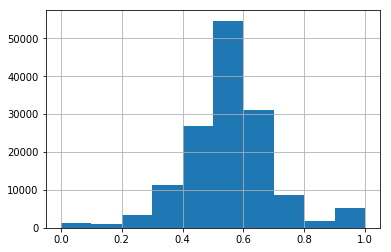

In [260]:
tele2_df.sentiment.hist()

In [261]:
tele2_df.to_csv('tele2df_sentiment_two.csv', sep=';', index=False)

### TSNE

Посмотрим на эмбендинги на основе T-SNE разложения, с целью обнаружения "аномалий"

In [310]:
emb=pd.read_csv('question_vectors.tsv', sep=' ', header=None)
all_qst=pd.read_table('all_questions.txt', names=['question'])

In [312]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import preprocessing, pipeline
from sklearn import decomposition
from sklearn.cluster import DBSCAN

Populating the interactive namespace from numpy and matplotlib


In [319]:
X=np.array(emb)
X_scale=preprocessing.scale(X)
X_minmax=preprocessing.minmax_scale(X)

In [320]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(random_state=17, )

X_tsne = tsne.fit_transform(X_minmax)

CPU times: user 13min 16s, sys: 3min 7s, total: 16min 24s
Wall time: 16min 23s


Text(0.5,1,'t-SNE projection')

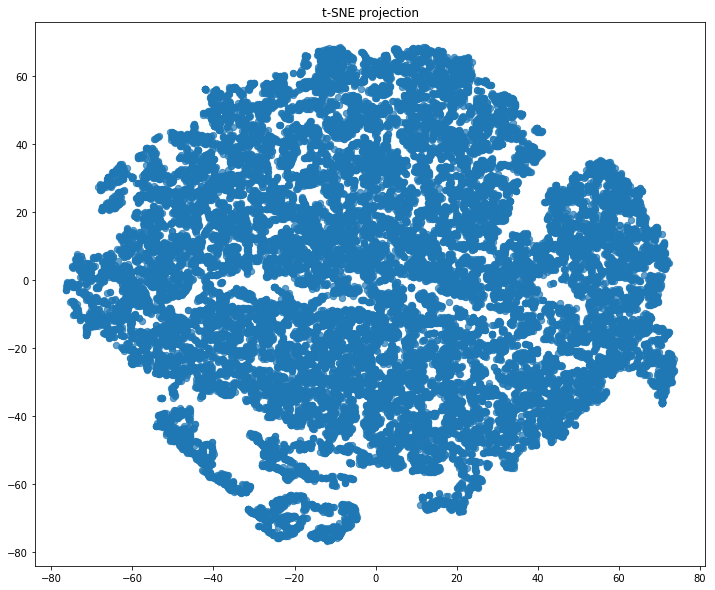

In [321]:
plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.title('t-SNE projection')

#### dbScan
Отловим аномалии unsupervised

In [381]:
db = DBSCAN(eps=4, min_samples=5, p=2).fit(X_tsne) #0.1 для X_reducet, 3-10 для X_tsne

Text(0.5,1,'DBSCAN. t-SNE projection')

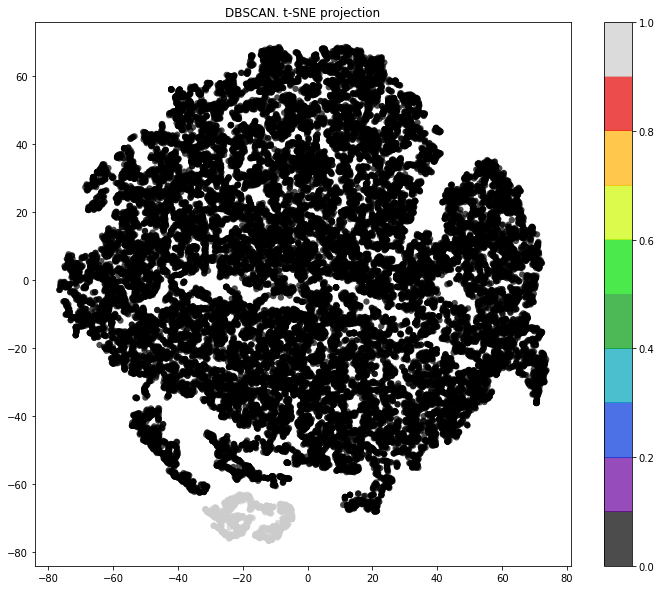

In [382]:
"""Как видно число кластеров получилось 3, при этом все они прекрасно идентифицируются"""

labels_tsne = db.labels_
plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_tsne, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('DBSCAN. t-SNE projection')

In [383]:
labels_tsne

array([0, 0, 0, ..., 0, 0, 0])

In [384]:
emb['tsne_group']=labels_tsne

In [385]:
emb[emb['tsne_group']>=1]['tsne_group'].index

Int64Index([  136,   290,   503,  1397,  1548,  1625,  1634,  1642,  1643,
             1660,
            ...
            30037, 30077, 30376, 32068, 32324, 32327, 32904, 33246, 33247,
            33248],
           dtype='int64', length=774)

In [386]:
all_qst.loc[emb[emb['tsne_group']==0]['tsne_group'].index]

,question
0,0 0 За компенсацию спасибо Вам лучше знать к...
1,04 05 18 В салоне г Вельска написала заявлени...
2,100 мб
3,100 мб за сколько рублей
4,104 это проверка баланса без учета Обещанног...
5,1 06 Вс по прежнему еще хуже стало Издеват...
6,107 номер телефона xxx xxx xx xx
7,10 хорошая консультация Но дорогие тарифы д...
8,1 13 2 Целый месяц В обоих случаях Оповещать з...
9,12 05 xxxxxг в 14 15 на мой номер xxx xxx xx ...


### PCA

Projecting 100-dimensional data to 2D


Text(0.5,1,'Scatter data')

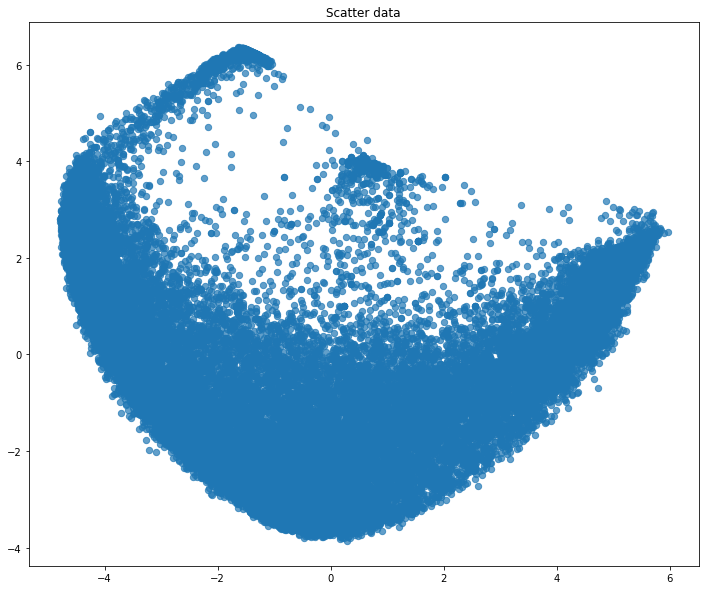

In [357]:
pca = decomposition.PCA(n_components=2)
X_centered=X-X.mean(axis=0)
X_reduced = pca.fit_transform(X_centered)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], 
            alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.title('Scatter data')

In [367]:
pca.explained_variance_ratio_

array([0.4389418 , 0.22975657])

In [368]:
sum(pca.explained_variance_ratio_)

0.6686983728700463

### ISOLATION FOREST
Обучим на эмбендингах supervised модель детекции аномальных обращений 

In [347]:
from sklearn.ensemble import IsolationForest


Text(0.5,1,'Scatter data')

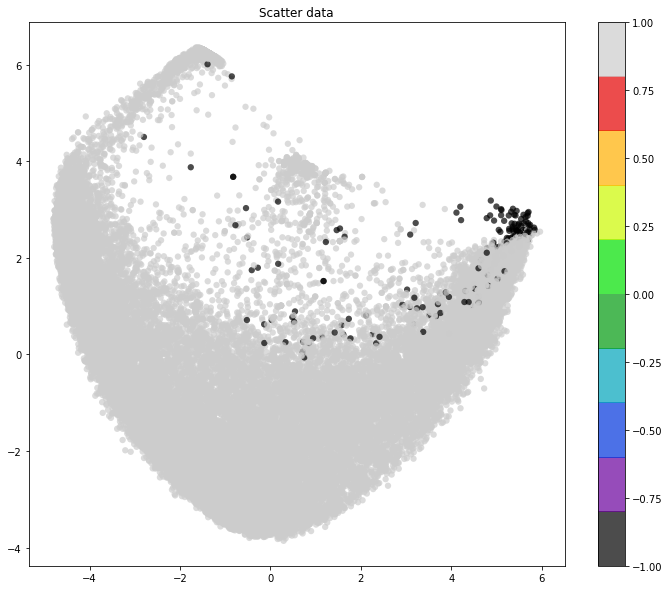

In [420]:
iso_f=IsolationForest(contamination=0.005, random_state=42, n_estimators=150)
iso_f.fit(X)
labels=iso_f.predict(X)
plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, 
            edgecolor='none',
            alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('Scatter data')

In [423]:
### Примеры "аномальных" с точки зрения алгоритма запросов
emb['isofor_group']=labels
all_qst.loc[emb[emb['isofor_group']==-1].index].head(100)

,question
69,35 регион Нет интернета
74,3G связь это какая скорость
85,4 g слабый
131,ghbdtn привет
137,G Стикеры
1261,xxxxx этот
1718,Ак алло
2077,Альметьевск пропадает сеть
2485,а у кого есь
2614,Безлимитный
